## Setup

### Importing Dependencies

In [1]:
# GPT-2 Tokenizer
from transformers import GPT2Tokenizer

# Torch for training models
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

# Data loading / Utilities
import os
import pickle
from functools import partial

# Transformer training dataset and collate function
from transformer_dataset import SentihoodDataset, sentihood_collate_fn

# Transformer model class
from transformer_model import TransformerModel

### Fixing Random Seeds for Reproducibility

In [2]:
seed = 42
torch.manual_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

### Defining Project Directories

In [3]:
proj_dir = "./QLens/" # Personalize if needed
data_dir = proj_dir + "Datasets/"
model_dir = proj_dir + "Model_Checkpoints/"

## Loading Data

In [4]:
# Loading saved Train and Test splits

train_path = data_dir + 'train.pickle'
test_path = data_dir + 'test.pickle'

with open(train_path, 'rb') as train_file:
    train_dict = pickle.load(train_file)

with open(test_path, 'rb') as test_file:
    test_dict = pickle.load(test_file)

In [5]:
# Resolving train and test splits into input/output segments

X_train = train_dict['X']
y_train = train_dict['y']

X_test = test_dict['X']
y_test = test_dict['y']

## Training Transformer Model

In [6]:
# Preparing for training

# Selecting the training device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# GPT-2 Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.add_special_tokens({'pad_token': '<PAD>', 'cls_token': '<CLS>'})

# Hyperparameters
d_embedding = 768   # Dimensionality of initial GPT-2 embeddings
d_model = 128       # Dimension of the model's feature space
num_heads = 4       # Number of attention heads
d_ff = 512          # Dimension of the inner MLP layer
batch_size = 16     # Number of sequences per batch
num_epochs = 10     # Number of training epochs
dropout_rate = 0.1  # Dropout rate

# Creating an instance of the Sentihood dataset for training
train_dataset = SentihoodDataset(X_train, y_train, tokenizer)

# Create DataLoader objects for batching
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn = partial(sentihood_collate_fn, pad_id = tokenizer.pad_token_id))

# Instantiating the simple Transformer model
model = TransformerModel(d_embedding = d_embedding,
                         d_model = d_model,
                         dim_feedforward = d_ff,
                         num_heads = num_heads,
                         dropout_rate = dropout_rate,
                         tokenizer_len = len(tokenizer))
model.to(device)

# Defining loss function, optimizer, and learning rate scheduler
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Starting training loop...


Epoch 1/10: 100%|██████████| 54/54 [00:00<00:00, 79.56it/s]


Epoch [1/10], Average Loss: 0.7718, Learning Rage: 0.0010


Epoch 2/10: 100%|██████████| 54/54 [00:00<00:00, 115.78it/s]


Epoch [2/10], Average Loss: 0.6551, Learning Rage: 0.0009


Epoch 3/10: 100%|██████████| 54/54 [00:00<00:00, 117.84it/s]


Epoch [3/10], Average Loss: 0.3180, Learning Rage: 0.0008


Epoch 4/10: 100%|██████████| 54/54 [00:00<00:00, 117.99it/s]


Epoch [4/10], Average Loss: 0.1518, Learning Rage: 0.0007


Epoch 5/10: 100%|██████████| 54/54 [00:00<00:00, 117.85it/s]


Epoch [5/10], Average Loss: 0.0811, Learning Rage: 0.0005


Epoch 6/10: 100%|██████████| 54/54 [00:00<00:00, 117.98it/s]


Epoch [6/10], Average Loss: 0.0464, Learning Rage: 0.0003


Epoch 7/10: 100%|██████████| 54/54 [00:00<00:00, 117.78it/s]


Epoch [7/10], Average Loss: 0.0154, Learning Rage: 0.0002


Epoch 8/10: 100%|██████████| 54/54 [00:00<00:00, 117.97it/s]


Epoch [8/10], Average Loss: 0.0048, Learning Rage: 0.0001


Epoch 9/10: 100%|██████████| 54/54 [00:00<00:00, 118.19it/s]


Epoch [9/10], Average Loss: 0.0026, Learning Rage: 0.0000


Epoch 10/10: 100%|██████████| 54/54 [00:00<00:00, 118.78it/s]


Epoch [10/10], Average Loss: 0.0023, Learning Rage: 0.0000
Training finished!
Checkpoint for Epoch 10 saved


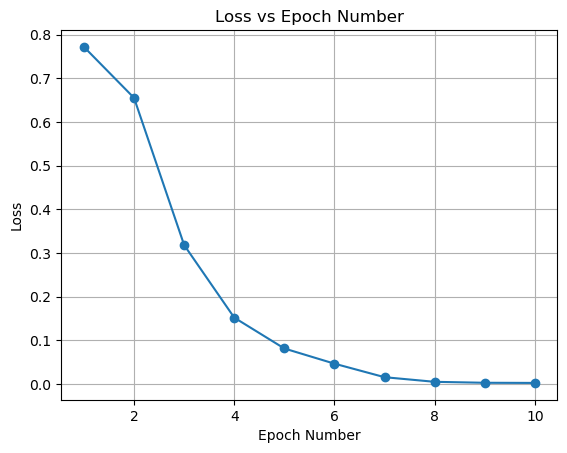

In [7]:
model.train_model(train_dataloader,
                 criterion,
                 optimizer,
                 num_epochs,
                 device,
                 model_dir,
                 scheduler)

## Evalutating the Transformer Model

In [8]:
test_dataset = SentihoodDataset(X_test, y_test, tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, collate_fn = partial(sentihood_collate_fn, pad_id = tokenizer.pad_token_id))

In [9]:
model.eval_model(test_dataloader,
                 criterion,
                 device)

Model Evaluation: 100%|██████████| 14/14 [00:00<00:00, 141.04it/s]


Test Loss: 1.0121, Accuracy: 0.7664
Test complete!
